In [ ]:
!pip install tensorflow

     |████████████████████████████████| 462 kB 9.0 MB/s 


In [ ]:
import re
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv1D, Embedding, GlobalAveragePooling1D 
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Reading Image Info from CSV and Cleaning

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Memotion/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df = df.drop(columns = ['text_ocr', 'humour', 'sarcasm', 'offensive', 'motivational'])
df.head()

,image_name,text_corrected,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,very_positive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,very_positive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
3,image_4.png,10 Year Challenge - Sweet Dee Edition,positive
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral


In [ ]:
cleaned = df.copy()
cleaned.dropna(inplace=True)
cleaned.isnull().any()

image_name           False
text_corrected       False
overall_sentiment    False
dtype: bool

In [ ]:
cleaned.shape

(6987, 3)

###Image Modelling

####Loading Images

In [ ]:
width = 100
height = 100
X = []
for i in tqdm(range(cleaned.shape[0])):
    if i in [119, 4799, 6781, 6784, 6786]:
        pass
    else:
        path = '/content/drive/My Drive/Memotion/images/'+cleaned['image_name'][i]
        img = image.load_img(path,target_size=(width,height,3))
        img = image.img_to_array(img)
        img = img/255.0
        X.append(img)
        
X = np.array(X)

 93%|█████████▎| 6511/6987 [37:11<02:24,  3.29it/s]/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
 96%|█████████▌| 6676/6987 [38:00<01:30,  3.44it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 6987/6987 [39:32<00:00,  2.94it/s]


In [ ]:
X

array([[[[0.5058824 , 0.3882353 , 0.38039216],
         [0.5058824 , 0.3882353 , 0.38039216],
         [0.5058824 , 0.3882353 , 0.38039216],
         ...,
         [0.38039216, 0.40392157, 0.39607844],
         [0.37254903, 0.39607844, 0.3882353 ],
         [0.35686275, 0.3764706 , 0.3882353 ]],

        [[0.5058824 , 0.3882353 , 0.38039216],
         [0.5019608 , 0.38431373, 0.3764706 ],
         [0.5058824 , 0.3882353 , 0.38039216],
         ...,
         [0.38039216, 0.40392157, 0.39607844],
         [0.37254903, 0.39607844, 0.3882353 ],
         [0.35686275, 0.3764706 , 0.3882353 ]],

        [[0.5058824 , 0.3882353 , 0.38039216],
         [0.5019608 , 0.38431373, 0.3764706 ],
         [0.5058824 , 0.3882353 , 0.38039216],
         ...,
         [0.38039216, 0.40392157, 0.39607844],
         [0.3764706 , 0.4       , 0.39215687],
         [0.36078432, 0.38039216, 0.39215687]],

        ...,

        [[0.45882353, 0.2784314 , 0.18431373],
         [0.5686275 , 0.27058825, 0.18039216]

In [ ]:
X.shape

(6982, 100, 100, 3)

Dropping few rows to make shape consistent

In [ ]:
rows_to_drop = ['image_120.jpg',
              'image_4800.jpg',
              'image_6782.jpg',
              'image_6785.jpg',
              'image_6787.jpg',
              'image_6988.jpg',
              'image_6989.jpg',
              'image_6990.png',
              'image_6991.jpg',
              'image_6992.jpg']

In [ ]:
for images in rows_to_drop:
    cleaned.drop(cleaned[cleaned['image_name'] == images].index, inplace=True)

In [ ]:
target = cleaned['overall_sentiment']
target = pd.get_dummies(target)
target.head()

,negative,neutral,positive,very_negative,very_positive
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,1,0,0
3,0,0,1,0,0
4,0,1,0,0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.2, stratify=target)

###Image Preprocessing



In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomContrast([.5,2]),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


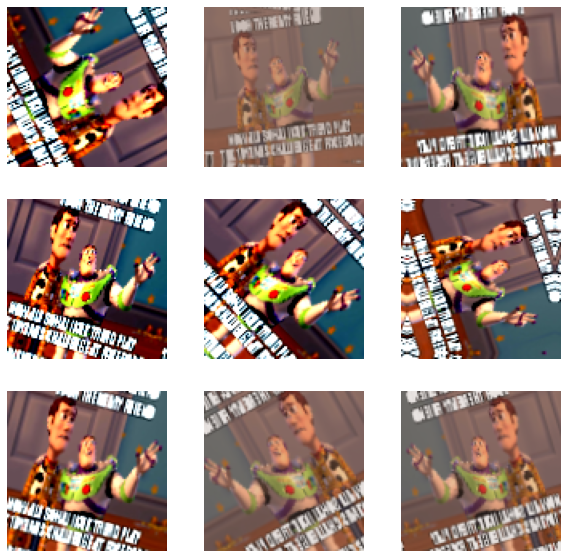

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(X)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

### Base Model

In [ ]:
base_model_1 = tf.keras.applications.ResNet50(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')
base_model_2 = tf.keras.applications.VGG16(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model_1.trainable = False
base_model_2.trainable = False

### Model for Image

In [ ]:
def image_model():
    image_input = tf.keras.Input(shape=(100, 100, 3), name = 'image_input')
    image_layers = data_augmentation(image_input)
    image_layers = preprocess_input(image_layers)
    layer_bm_1 = base_model_1(image_input, training=False)
    layer_bm_1 = Conv2D(2048, kernel_size=2,padding='valid')(layer_bm_1)
    layer_bm_1 = Dense(512)(layer_bm_1)
    layer_bm_2 = base_model_2(image_input, training=False)
    layer_bm_2 = Dense(512)(layer_bm_2)
    layers = tf.keras.layers.concatenate([layer_bm_1, layer_bm_2])
    image_layers = GlobalAveragePooling2D()(layers)
    image_layers = Dropout(0.2, name = 'dropout_layer')(image_layers)
    return image_input, image_layers

In [ ]:
image_input, image_layers = image_model()

# Text Modelling

### Standardization and Cleaning

In [ ]:
def standardization(data):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: re.sub(r'\d+', '', x))
    data = data.apply(lambda x: re.sub(r'.com', '', x, flags=re.MULTILINE))
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return data

cleaned['text_corrected'] = standardization(cleaned.text_corrected)

### Vectorizing Layers

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
vocab_size = 10000
sequence_length = 50

vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

text_ds = np.asarray(cleaned['text_corrected'])
vectorize_layer.adapt(tf.convert_to_tensor(text_ds))

In [ ]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(cleaned.text_corrected, target, test_size = 0.2, stratify=target)

In [ ]:
embedding_dim=16

def text_model():
    text_input = tf.keras.Input(shape=(None,), dtype=tf.string, name='text')
    text_layers = vectorize_layer(text_input)
    text_layers = tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding")(text_layers)

    text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, activation='relu', return_sequences=True))(text_layers)
    text_layers = tf.keras.layers.BatchNormalization()(text_layers)
    text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, activation='relu', return_sequences=True))(text_layers)
    text_layers = tf.keras.layers.BatchNormalization()(text_layers)

    text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
    
    text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
    
    text_layers = tf.keras.layers.GlobalMaxPooling1D()(text_layers)

    text_layers = tf.keras.layers.Dense(2048, activation="relu")(text_layers)
    text_layers = tf.keras.layers.Dropout(0.5)(text_layers)
    return text_input, text_layers

text_input, text_layers = text_model()

# Combining and Evaluating

### Task A: Overall Sentiment

In [ ]:
def model(layer_1, layer_2, image_input, text_input):
    concatenate = tf.keras.layers.concatenate([layer_1, layer_2], axis=1)
    semi_final_layer = tf.keras.layers.Dense(2048, activation='softmax')(concatenate)

    prediction_layer = tf.keras.layers.Dense(5, activation='sigmoid', name = 'task_a')

    output = prediction_layer(semi_final_layer)

    model = tf.keras.Model(inputs = [image_input, text_input] , 
                           outputs = output)
    return model

In [ ]:
model = model(image_layers, text_layers, image_input, text_input)

In [ ]:
import os
# Define the checkpoint directory to store the checkpoints
checkpoint_dir = './training_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [ ]:
# Function for decaying the learning rate.
# You can define any decay function you need.
def decay(epoch):
  if epoch < 3:
    return 1e-1
  elif epoch >= 3 and epoch < 5:
    return 1e-2
  else:
    return 1e-5

In [ ]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['binary_accuracy', 'accuracy'])

history = model.fit(x = {"image_input": X_train, "text_input": X_text_train},
                    y = y_train,
                    batch_size=256,
                    epochs=25,
                    callbacks=callbacks
                   )

In [ ]:
df_history = pd.DataFrame(history.history)
df_history

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
fig.tight_layout(pad=5.0)

axes[0].plot(df_history.loss)
axes[0].set_xlabel('No of Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss vs Epochs')

axes[1].plot(df_history.binary_accuracy)
axes[1].plot(df_history.accuracy)
axes[1].set_xlabel('No of Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Accuracy vs Epochs')
axes[1].legend()
plt.show()

In [ ]:
eval_ = model.evaluate(x = {"image_input": X_test, "text_input": X_text_test},
                    y = y_test,
                    batch_size=32,
                    verbose=1
                   )

In [ ]:
prediction = model.predict(x = {"image_input": X_test, "text_input": X_text_test})
prediction = np.array(prediction)
prediction = np.squeeze(prediction)
prediction = 1/(1+np.exp(-np.array(prediction)))
prediction = np.where(prediction > 0.5, 1, 0)
y_true = y_test.values

micro_f1_score = f1_score(y_true[:,1], prediction[:,1], average='micro')
macro_f1_score = f1_score(y_true[:,1], prediction[:,1], average='macro')

print("Micro F1 score for Task A is ", micro_f1_score)
print("Macro F1 score for Task A is ", macro_f1_score)

In [ ]:
import random

fig, axes = plt.subplots(1,2, figsize=(20, 4))
fig.tight_layout(pad=5.0)


x = list(y_test.columns)

axes[0].imshow(X[random.randint(0,X_test.shape[0]),:,:,:])

axes[1].bar(x, model.predict(x = {"image_input": X_test, "text_input": X_text_test})[random.randint(0,X_test.shape[0]),:])
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Probanility')
axes[1].set_title('Humuor Prob.')
axes[1].set_xticks(x)
axes[1].set_ylim(0,1)
plt.show()

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(20, 4))
fig.tight_layout(pad=5.0)


x = list(y_test.columns)

axes[0].imshow(X[random.randint(0,X_test.shape[0]),:,:,:])

axes[1].bar(x, model.predict(x = {"image_input": X_test, "text_input": X_text_test})[random.randint(0,X_test.shape[0]),:])
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Probanility')
axes[1].set_title('Humuor Prob.')
axes[1].set_xticks(x)
axes[1].set_ylim(0,1)
plt.show()

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(20, 4))
fig.tight_layout(pad=5.0)


x = list(y_test.columns)

axes[0].imshow(X[random.randint(0,X_test.shape[0]),:,:,:])

axes[1].bar(x, model.predict(x = {"image_input": X_test, "text_input": X_text_test})[random.randint(0,X_test.shape[0]),:])
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Probanility')
axes[1].set_title('Humuor Prob.')
axes[1].set_xticks(x)
axes[1].set_ylim(0,1)
plt.show()

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(20, 4))
fig.tight_layout(pad=5.0)


x = list(y_test.columns)

axes[0].imshow(X[random.randint(0,X_test.shape[0]),:,:,:])

axes[1].bar(x, model.predict(x = {"image_input": X_test, "text_input": X_text_test})[random.randint(0,X_test.shape[0]),:])
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Probanility')
axes[1].set_title('Humuor Prob.')
axes[1].set_xticks(x)
axes[1].set_ylim(0,1)
plt.show()

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(20, 4))
fig.tight_layout(pad=5.0)


x = list(y_test.columns)

axes[0].imshow(X[random.randint(0,X_test.shape[0]),:,:,:])

axes[1].bar(x, model.predict(x = {"image_input": X_test, "text_input": X_text_test})[random.randint(0,X_test.shape[0]),:])
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Probanility')
axes[1].set_title('Humuor Prob.')
axes[1].set_xticks(x)
axes[1].set_ylim(0,1)
plt.show()

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)